# Code for making predictions with and without news features

## Libraries/Data required

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [2]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column

In [3]:
# df['district'] = df['district'].str.replace("Center", "").str.replace("South", "").str.replace("North", "").str.replace("East", "").str.replace("West", "").str.strip()
print(len(df['district'].unique()))

78


In [4]:
df.set_index(["date", "district"], inplace=True) # Set index
df

,,country,district_code,centx,centy,year_month,year,month,ipc,ha,ndvi_mean,...,et_mean,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct
date,district,,,,,,,,,,,,,,,,,,,,,
2007-01-01,Bor,South Sudan,74,32.00486,6.465644,2007_01,2007,1,NaN,NaN,0.345851,...,0.671249,0.048880,0,0,0.561363,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-02-01,Bor,South Sudan,74,32.00486,6.465644,2007_02,2007,2,NaN,NaN,0.307600,...,0.129184,-0.457928,0,0,0.565693,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-03-01,Bor,South Sudan,74,32.00486,6.465644,2007_03,2007,3,NaN,NaN,0.278344,...,1.025460,-0.590175,0,0,0.592437,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-04-01,Bor,South Sudan,74,32.00486,6.465644,2007_04,2007,4,NaN,NaN,0.303320,...,3.846809,-1.845536,0,0,0.605352,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-05-01,Bor,South Sudan,74,32.00486,6.465644,2007_05,2007,5,NaN,NaN,0.413716,...,8.316274,-2.972735,0,0,0.618699,14008.3300,7.961984,239344.0,11393.760,90.8503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,Malakal,South Sudan,151,31.64280,9.658457,2019_10,2019,10,3.0,0.0,0.681990,...,22.853360,6.053181,1,0,82.872570,757.7855,13.068690,102228.0,7145.909,85.5000
2019-11-01,Malakal,South Sudan,151,31.64280,9.658457,2019_11,2019,11,NaN,NaN,0.556748,...,13.372410,8.745254,0,0,87.728720,757.7855,13.068690,102228.0,7145.909,85.5000
2019-12-01,Malakal,South Sudan,151,31.64280,9.658457,2019_12,2019,12,NaN,NaN,0.400063,...,3.089540,1.698060,0,0,93.566750,757.7855,13.068690,102228.0,7145.909,85.5000


## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

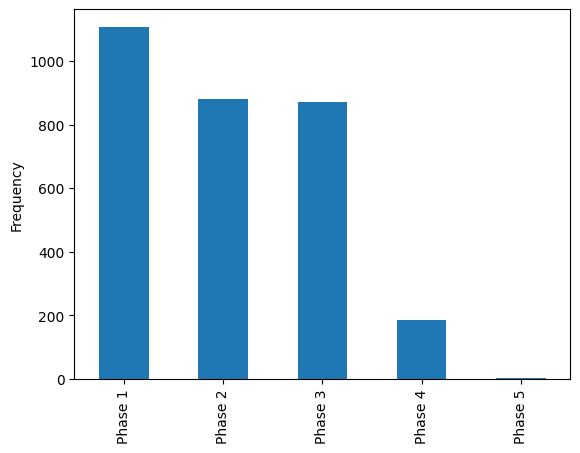

In [5]:
ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

/tmp/ipykernel_71809/480331542.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world


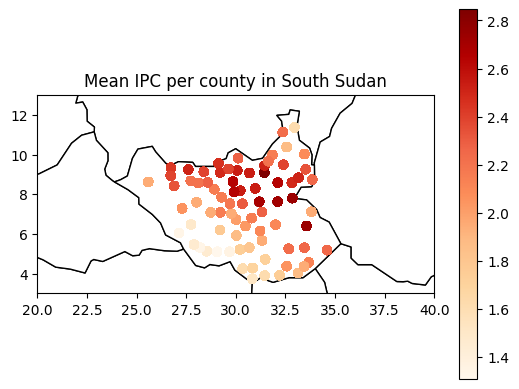

In [6]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [7]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [8]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [9]:
df

,,country,district_code,centx,centy,year_month,year,month,ipc,ha,ndvi_mean,...,et_mean,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct
date,district,,,,,,,,,,,,,,,,,,,,,
2007-01-01,Bor,South Sudan,74,32.00486,6.465644,2007_01,2007,1,NaN,NaN,0.345851,...,0.671249,0.048880,0,0,0.561363,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-02-01,Bor,South Sudan,74,32.00486,6.465644,2007_02,2007,2,NaN,NaN,0.307600,...,0.129184,-0.457928,0,0,0.565693,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-03-01,Bor,South Sudan,74,32.00486,6.465644,2007_03,2007,3,NaN,NaN,0.278344,...,1.025460,-0.590175,0,0,0.592437,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-04-01,Bor,South Sudan,74,32.00486,6.465644,2007_04,2007,4,NaN,NaN,0.303320,...,3.846809,-1.845536,0,0,0.605352,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-05-01,Bor,South Sudan,74,32.00486,6.465644,2007_05,2007,5,NaN,NaN,0.413716,...,8.316274,-2.972735,0,0,0.618699,14008.3300,7.961984,239344.0,11393.760,90.8503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,Malakal,South Sudan,151,31.64280,9.658457,2019_10,2019,10,3.0,0.0,0.681990,...,22.853360,6.053181,1,0,82.872570,757.7855,13.068690,102228.0,7145.909,85.5000
2019-11-01,Malakal,South Sudan,151,31.64280,9.658457,2019_11,2019,11,NaN,NaN,0.556748,...,13.372410,8.745254,0,0,87.728720,757.7855,13.068690,102228.0,7145.909,85.5000
2019-12-01,Malakal,South Sudan,151,31.64280,9.658457,2019_12,2019,12,NaN,NaN,0.400063,...,3.089540,1.698060,0,0,93.566750,757.7855,13.068690,102228.0,7145.909,85.5000


In [10]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom', 'ruggedness_mean', 'pop', 'cropland_pct', 'sum_fatalities', 'et_anom', 'rain_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
# df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
# df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns, len(df.columns) # View the newly created columns

(Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
        'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
        'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
        'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
        'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
        'ruggedness_mean_lag_3', 'pop_lag_3', 'cropland_pct_lag_3',
        'sum_fatalities_lag_3', 'et_anom_lag_3', 'rain_anom_lag_3',
        'food_price_idx_lag_3', 'ipc_lag_1'],
       dtype='object'),
 33)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12324 entries, (Timestamp('2007-01-01 00:00:00'), 'Bor') to (Timestamp('2020-02-01 00:00:00'), 'Malakal')
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                12324 non-null  object 
 1   district_code          12324 non-null  int64  
 2   centx                  12324 non-null  float64
 3   centy                  12324 non-null  float64
 4   year_month             12324 non-null  object 
 5   year                   12324 non-null  int64  
 6   month                  12324 non-null  int64  
 7   ipc                    3042 non-null   float64
 8   ha                     2184 non-null   float64
 9   ndvi_mean              12324 non-null  float64
 10  ndvi_anom              12324 non-null  float64
 11  rain_mean              12324 non-null  float64
 12  rain_anom              12324 non-null  float64
 13  et_mean                123

In [12]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     190.8
Date:                Tue, 10 Oct 2023   Prob (F-statistic):          3.25e-254
Time:                        16:51:52   Log-Likelihood:                -565.50
No. Observations:                1430   AIC:                             1153.
Df Residuals:                    1419   BIC:                             1211.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.75

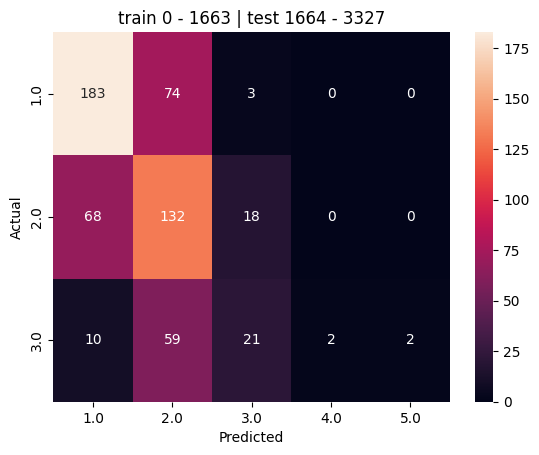

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     353.2
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:51:52   Log-Likelihood:                -1827.4
No. Observations:                3094   AIC:                             3677.
Df Residuals:                    3083   BIC:                             3743.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.16

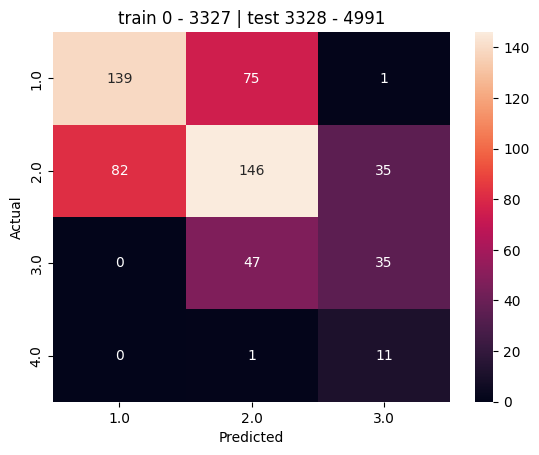

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     553.8
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:51:53   Log-Likelihood:                -2988.8
No. Observations:                4758   AIC:                             6000.
Df Residuals:                    4747   BIC:                             6071.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.10

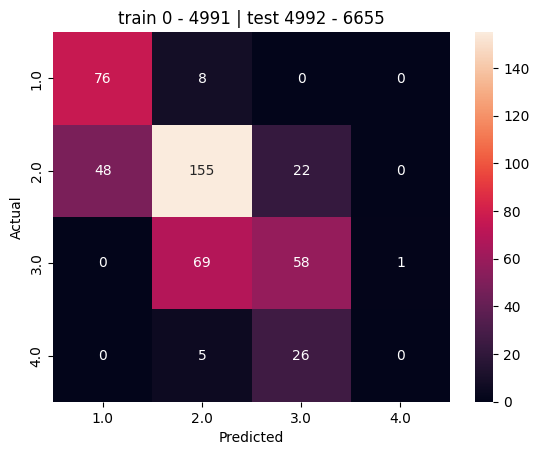

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     1019.
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:51:53   Log-Likelihood:                -4104.6
No. Observations:                6422   AIC:                             8231.
Df Residuals:                    6411   BIC:                             8306.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.15

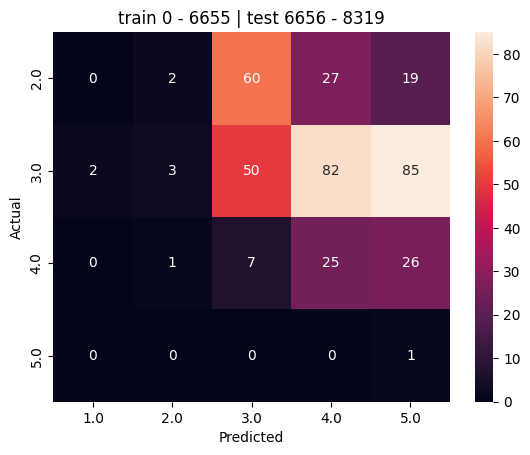

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     1724.
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:51:54   Log-Likelihood:                -5365.2
No. Observations:                8086   AIC:                         1.075e+04
Df Residuals:                    8075   BIC:                         1.083e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.30

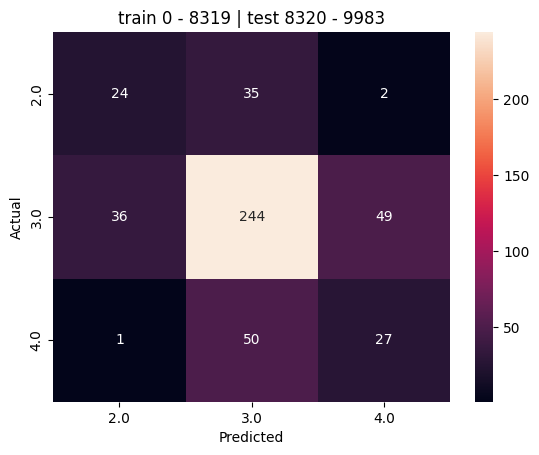

Mean MAE: 0.65
Mean R2: 0.59


<Figure size 640x480 with 0 Axes>

In [13]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [14]:
news_df = pd.read_csv(data_dir + "df_news_districted.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [15]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2011-05-01 to 2023-04-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hunger        139 non-null    float64
 1   refugees      139 non-null    float64
 2   conflict      139 non-null    float64
 3   humanitarian  139 non-null    float64
dtypes: float64(4)
memory usage: 5.6 KB


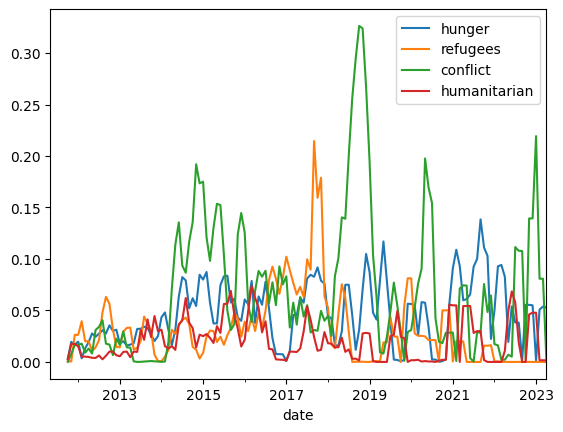

In [16]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])

news_features.plot();
news_features.info()

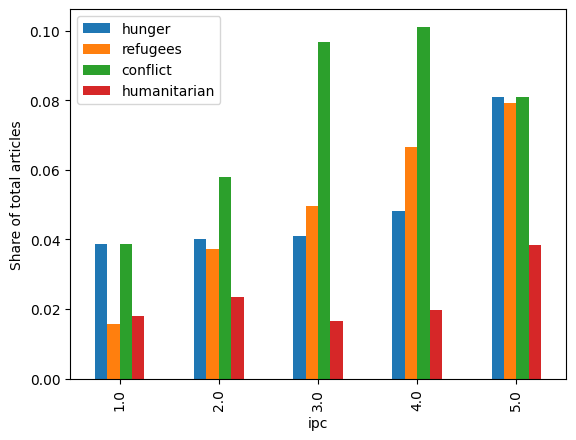

In [17]:
# Get the mean share of articles per ipc for the different topics
combined = (
    pd.DataFrame(y['ipc'])
    .join(news_df.groupby(["date"])["hunger"].mean())
    .join(news_df.groupby(["date"])["refugees"].mean())
    .join(news_df.groupby(["date"])["conflict"].mean())
    .join(news_df.groupby(["date"])["humanitarian"].mean())
)


# Plot the mean share of articles per ipc value for the different topics
combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
    kind="bar", ylabel="Share of total articles"
);

## Predicting using news features

In [18]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [19]:
df

country  district_code     centx     centy  \
date       district                                                       
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939   
           Akobo         South Sudan            114  32.85308  7.799214   
           Anzara        South Sudan             86  28.20598  5.309739   
           Aweil Center  South Sudan            128  26.89562  8.417934   
           Aweil East    South Sudan            141  27.61364  9.243139   
...                              ...            ...       ...       ...   
2020-02-01 Wulu          South Sudan            105  29.20889  6.200243   
           Yambio        South Sudan             82  28.54729  5.124909   
           Yei           South Sudan             81  30.34454  4.252148   
           Yirol East    South Sudan            107  30.80245  6.793194   
           Yirol West    South Sudan            101  30.48698  6.395244   

                        year_month  year  month  ipc   ha  ndvi_mean  ...  \
date       district                                                   ...   
2009-07-01 Abiemnhom       2009_07  2009      7  2.0  NaN   0.698165  ...   
           Akobo           2009_07  2009      7  4.0  NaN   0.474723  ...   
           Anzara          2009_07  2009      7  1.0  NaN   0.812001  ...   
           Aweil Center    2009_07  2009      7  2.0  NaN   0.723154  ...   
           Aweil East      2009_07  2009      7  3.0  NaN   0.547611  ...   
...                            ...   ...    ...  ...  ...        ...  ...   
2020-02-01 Wulu            2020_02  2020      2  2.0  0.0   0.374735  ...   
           Yambio          2020_02  2020      2  3.0  0.0   0.468085  ...   
           Yei             2020_02  2020      2  3.0  0.0   0.452878  ...   
           Yirol East      2020_02  2020      2  4.0  0.0   0.410408  ...   
           Yirol West      2020_02  2020      2  3.0  0.0   0.319411  ...   

                         cropland_pct_lag_3  sum_fatalities_lag_3  \
date       district                                                 
2009-07-01 Abiemnhom               1.742261              0.000000   
           Akobo                  10.046920             91.666667   
           Anzara                 18.819290              0.000000   
           Aweil Center            0.173833              0.000000   
           Aweil East             26.804220              0.000000   
...                                     ...                   ...   
2020-02-01 Wulu                    0.032678              0.000000   
           Yambio                 19.126490              0.166667   
           Yei                    16.303490              3.666667   
           Yirol East              2.482445              0.000000   
           Yirol West              0.462767              4.833333   

                         et_anom_lag_3  rain_anom_lag_3  food_price_idx_lag_3  \
date       district                                                             
2009-07-01 Abiemnhom          0.545964        -0.151423              0.007091   
           Akobo             -0.187350         0.376495              0.005769   
           Anzara            -0.406066        -0.346092              0.005331   
           Aweil Center       0.383011        -0.016475              0.023279   
           Aweil East         0.232048         0.149657              0.013091   
...                                ...              ...                   ...   
2020-02-01 Wulu               3.509945         1.501147              2.463037   
           Yambio             3.110487         0.237580              2.371327   
           Yei                4.350195         3.177643              3.138777   
           Yirol East         6.765314         2.721873              3.468092   
           Yirol West         6.312871         1.372882              3.407927   

                         ipc_lag_1    hunger  refugees  conflict  humanitarian  
date       distric

In [20]:
X.dropna()

const  count_violence_lag_3  ndvi_anom_lag_3  \
date       district                                                     
2009-10-01 Abiemnhom       1.0              0.000000        90.359368   
           Akobo           1.0              0.500000        98.679930   
           Anzara          1.0              0.833333       103.101368   
           Aweil Center    1.0              0.000000       104.416932   
           Aweil East      1.0              0.000000        92.302082   
...                        ...                   ...              ...   
2020-02-01 Wulu            1.0              0.000000       103.909292   
           Yambio          1.0              0.500000       101.517510   
           Yei             1.0              2.333333       102.151617   
           Yirol East      1.0              0.166667       103.811285   
           Yirol West      1.0              0.833333       102.977952   

                         ruggedness_mean_lag_3  pop_lag_3  cropland_pct_lag_3  \
date       district                                                             
2009-10-01 Abiemnhom                 11004.640    20702.0            1.742261   
           Akobo                      2787.772   158222.0           10.046920   
           Anzara                    51381.880    76442.0           18.819290   
           Aweil Center               3754.860    48376.0            0.173833   
           Aweil East                 3544.279   345977.0           26.804220   
...                                        ...        ...                 ...   
2020-02-01 Wulu                      40366.550    49743.0            0.032678   
           Yambio                    60628.160    86880.0           19.126490   
           Yei                       75813.310   109399.0           16.303490   
           Yirol East                18421.020   162544.0            2.482445   
           Yirol West                25073.430   154856.0            0.462767   

                         sum_fatalities_lag_3  et_anom_lag_3  rain_anom_lag_3  \
date       district                                                             
2009-10-01 Abiemnhom                 0.000000      -2.496336        -2.897726   
           Akobo                    68.500000      -0.494149        -4.256842   
           Anzara                    0.166667      -0.159782        -2.592554   
           Aweil Center              0.000000      -1.159250        -2.480714   
           Aweil East                0.000000      -1.629106        -2.408593   
...                                       ...            ...              ...   
2020-02-01 Wulu                      0.000000       3.509945         1.501147   
           Yambio                    0.166667       3.110487         0.237580   
           Yei                       3.666667       4.350195         3.177643   
           Yirol East                0.000000       6.765314         2.721873   
           Yirol West                4.833333       6.312871         1.372882   

                         food_price_idx_lag_3  ipc_lag_1  
date       district                                       
2009-10-01 Abiemnhom                 0.013112        2.0  
           Akobo                     0.027102        4.0  
           Anzara                    0.022304        1.0  
           Aweil Center              0.036645        2.0  
           Aweil East                0.026709        3.0  
...                                       ...        ...  
2020-02-01 Wulu                      2.463037        2.0  
           Yambio                    2.371327        2.0  
           Yei                       3.138777        3.0  
           Yirol East                3.468092        3.0  
           Yirol West                3.407927        3.0  

[2964 rows x 11 columns]

In [21]:
y = y[X['ipc_lag_1'].notnull()]
X = X[X['ipc_lag_1'].notnull()]

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     190.8
Date:                Tue, 10 Oct 2023   Prob (F-statistic):          3.25e-254
Time:                        16:52:04   Log-Likelihood:                -565.50
No. Observations:                1430   AIC:                             1153.
Df Residuals:                    1419   BIC:                             1211.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.75

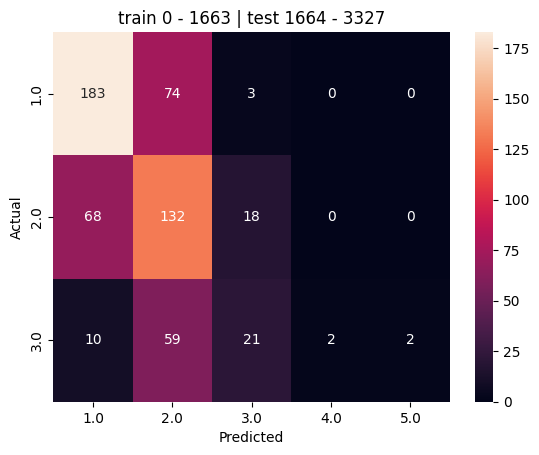

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     144.4
Date:                Tue, 10 Oct 2023   Prob (F-statistic):          5.74e-246
Time:                        16:52:05   Log-Likelihood:                -706.65
No. Observations:                1222   AIC:                             1443.
Df Residuals:                    1207   BIC:                             1520.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.74

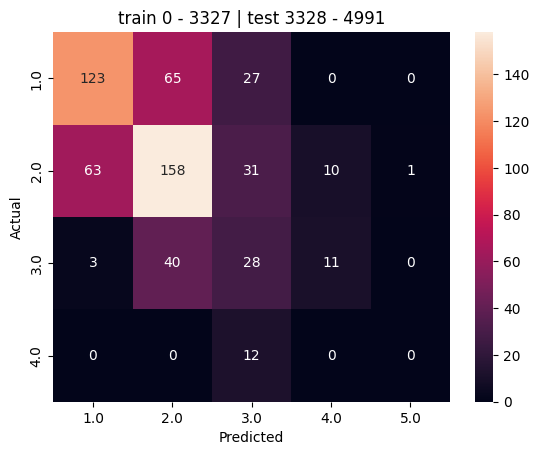

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     290.9
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:52:05   Log-Likelihood:                -1811.0
No. Observations:                2886   AIC:                             3652.
Df Residuals:                    2871   BIC:                             3742.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.09

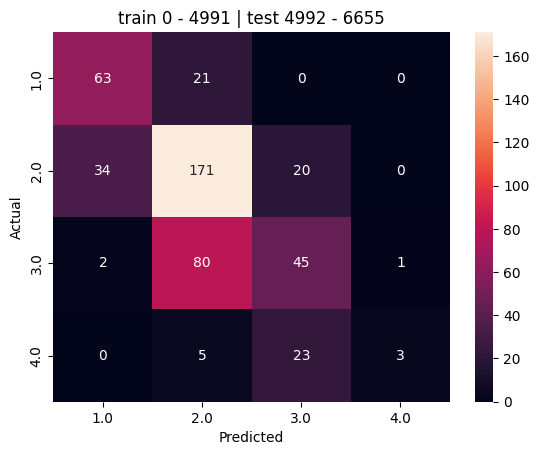

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     556.3
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:52:06   Log-Likelihood:                -2980.7
No. Observations:                4550   AIC:                             5991.
Df Residuals:                    4535   BIC:                             6088.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.57

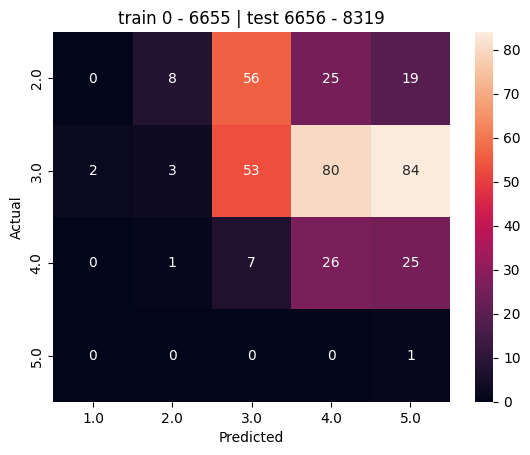

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     941.6
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:52:07   Log-Likelihood:                -4212.3
No. Observations:                6214   AIC:                             8455.
Df Residuals:                    6199   BIC:                             8556.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.37

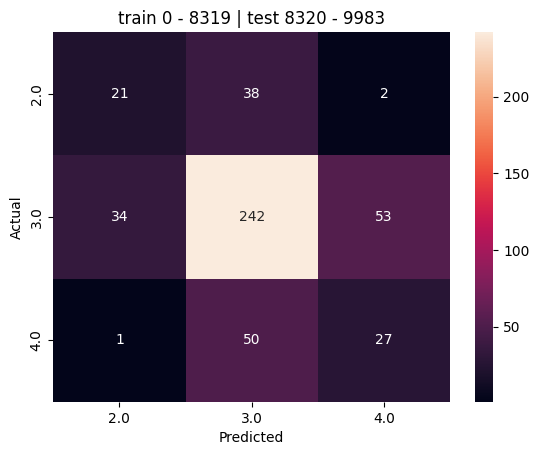

Mean MAE: 0.68
Mean R2: 0.62


<Figure size 640x480 with 0 Axes>

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# df_prep = df.copy().iloc[:, [7] + list(range(-10, 0))].dropna()


X = df.iloc[:, -14:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()
f1_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data

    # Calculate accuracy
    # accuracy_values.append(accuracy_score(y_val['ipc'].values, np.round(y_pred)))

    # Calculate F1 score
    # f1_values.append(f1_score(y_val['ipc'].values, np.round(y_pred), average='weighted'))
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
# print(f"Mean Accuracy: {np.mean(accuracy_values):.2f}") # Print R2
# print(f"Mean f1: {np.mean(f1_values):.2f}") # Print R2

In [23]:
# from sklearn.datasets import make_hastie_10_2
# from sklearn.metrics import accuracy_score, make_scorer
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score
# from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, mean_absolute_error
# from sklearn.linear_model import Ridge


# # df_prep = df.copy().iloc[:, [7] + list(range(-10, 0))].dropna()


# X = df.iloc[:, -16:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# # Initinalize empty lists to score scores
# mae_values = list()
# r2_values = list()
# f1_values = list()

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
#     X_train = X_train.dropna(axis=1, how='all').copy()
#     X_test = X_test[X_train.columns]
    
#     #Interpolate training data to generate more training points
#     X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     X_train.reset_index(level=0, drop=True, inplace=True)
#     y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     y_train.reset_index(level=0, drop=True, inplace=True)
    
#     model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
#     # model = Ridge(alpha=1)

#     results = model.fit() # Get model results on training data

#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test).T[0] # Run model on test data
#     # y_pred = y_pred.T[0]

#     # Append results to respective lists
#     mae_values.append((y_pred - y_val['ipc']).abs().mean())
#     # f1_values(f1_score)    

#     cur_r2 = results.rsquared
#     # cur_r2 = r2_score(y_pred=results.predict(X_train),
#     #                   y_true=y_train['ipc'])
#     r2_values.append(cur_r2)

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
# print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
# print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

We see that the R2 has risen somewhat compared to the baseline.

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [24]:
# df.sort_index(level=0, inplace=True) # Sort DataFrame by date
# df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [25]:
# X = df.iloc[:, -10:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
# acc_values = list() # Initinalize empty lists to score accuracy scores

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
#     y_binary = y > 2 # Convert y to binary variable
#     y_binary[y.isna()] = pd.NA # Conserve NaN values
#     y_binary = y_binary.astype("float32") # Convert y to float

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
#     #Interpolate training data to generate more training points
# X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
# X_train.reset_index(level=0, drop=True, inplace=True)
# y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
# y_train.reset_index(level=0, drop=True, inplace=True)
    
#     cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
#     model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
#     results = model.fit() # Get model results on training data
#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test[cols]) # Run model on test data

#     # Convert prediction and validation to boolean
#     y_pred = y_pred.round().astype(bool)
#     y_val = y_val.round().astype(bool)

#     # Drop all rows from prediction and validation where validation is null
#     y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
#     y_val.dropna(inplace=True)

#     acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
# print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc

In [26]:
y = y[X['ipc_lag_1'].notnull()]
X = X[X['ipc_lag_1'].notnull()]

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have already loaded your data into X_train, X_test, y_train, and y_test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=69)

# Normalize your data (optional, but recommended)
scaler = StandardScaler()
X_train_model = scaler.fit_transform(X_train.values)
X_test_model = scaler.transform(X_test.values)

# Convert data to PyTorch tensors
X_train_model = torch.FloatTensor(X_train_model)
X_test_model = torch.FloatTensor(X_test_model)
y_train_model = torch.LongTensor(y_train.values)
y_test_model = torch.LongTensor(y_test.values)

# # Subtract 1 from the target labels to make them range from 0 to 4
y_train_model = torch.LongTensor([label - 1 for label in y_train_model]).unsqueeze(dim=1)
y_test_model = torch.LongTensor([label - 1 for label in y_test_model]).unsqueeze(dim=1)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_model, y_train_model)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_model, y_test_model)
test_loader = DataLoader(test_dataset, batch_size=32)


In [28]:
from tqdm.notebook import tqdm

class HungerModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HungerModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Define class weights based on ordinal distance
class_weights = torch.tensor([3.0, 3.0, 3.0, 1.0, 1.0])

input_size = X_train.shape[1]
num_classes = 5

model = HungerModel(input_size, num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 1500
best_loss = 10000

for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Print training loss for each epoch
    
    if loss < best_loss:
        best_loss = loss
        # Save the model checkpoint
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

model = HungerModel(input_size, num_classes)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set the model to evaluation mode

  0%|          | 0/1500 [00:00<?, ?it/s]

HungerModel(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)

In [29]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, _ = batch
        outputs = model(inputs)
        # Apply softmax and get predicted classes using argmax
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        # Print predicted classes (1 to 5)
        # print(predicted_classes.numpy())


Confusion Matrix:
[[125  42   1   0]
 [ 49 103  49   2]
 [ 12  30 121  29]
 [  1   3  14  12]]
Accuracy: 0.6087689713322091
F1 Score: 0.60906928733123


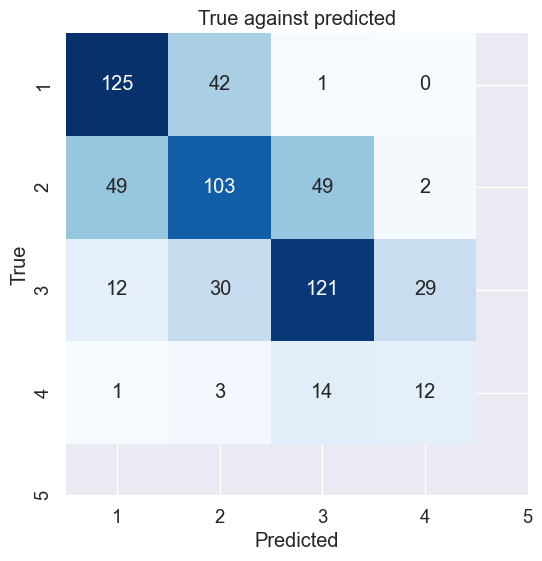

Accuracy: 0.6087689713322091
F1 Score: 0.60906928733123
Mean Absolute Error (MAE): 0.42495784148397975
Mean Squared Error (MSE): 0.4957841483979764


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
predicted_probabilities = []  # Added for MSE and MAE

combined_dataset = ConcatDataset([
    TensorDataset(X_train_model, y_train_model),
    TensorDataset(X_test_model, y_test_model)
])

combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        # Apply softmax and get predicted classes using argmax
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted_classes.numpy())
        predicted_probabilities.extend(probabilities.numpy())  # Added for MSE and MAE

# Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Confusion Matrix:")
print(confusion)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
# Calculate MSE and MAE
# Calculate MSE and MAE

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size if needed
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=[str(i+1) for i in range(num_classes)],
            yticklabels=[str(i+1) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('True against predicted')
plt.show()

print("Accuracy:", accuracy)
print("F1 Score:", f1)
# ... (remaining code for MSE and MAE)

# Convert true_labels to one-hot encoded format
num_classes = 5  # Assuming you have 5 classes
true_labels_onehot = np.zeros((len(true_labels), num_classes))
true_labels_onehot[np.arange(len(true_labels)), true_labels] = 1

mse = np.mean(np.square(np.array(predicted_labels) - [i[0] for i in true_labels]))
mae = np.mean(np.abs(np.array(predicted_labels) - [i[0] for i in true_labels]))

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
